# Data Load

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
train = pd.read_csv('/content/data_train.csv')

uploaded = files.upload()
test = pd.read_csv('/content/data_test.csv')


uploaded = files.upload()
sample_solution = pd.read_csv('/content/sample_solution.csv', sep=';')

Saving data_train.csv to data_train.csv


Saving data_test.csv to data_test.csv


Saving sample_solution.csv to sample_solution.csv


# Install Lib

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from textblob import TextBlob

!pip install scikit-learn pandas numpy xgboost lightgbm textblob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# EDA

In [ ]:
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("\nTrain Info:")
print(train.info())

Train Shape: (4320, 11)
Test Shape: (1080, 10)

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       4320 non-null   int64 
 1   Category         4320 non-null   object
 2   Product Name     4320 non-null   object
 3   Location         4320 non-null   object
 4   Price            4320 non-null   int64 
 5   Overall Rating   4320 non-null   int64 
 6   Number Sold      4320 non-null   int64 
 7   Total Review     4320 non-null   int64 
 8   Customer Rating  4320 non-null   int64 
 9   Customer Review  4320 non-null   object
 10  Emotion          4320 non-null   object
dtypes: int64(6), object(5)
memory usage: 371.4+ KB
None


In [ ]:
print("\nMissing Values:")
print(train.isnull().sum())


Missing Values:
Unnamed: 0         0
Category           0
Product Name       0
Location           0
Price              0
Overall Rating     0
Number Sold        0
Total Review       0
Customer Rating    0
Customer Review    0
Emotion            0
dtype: int64


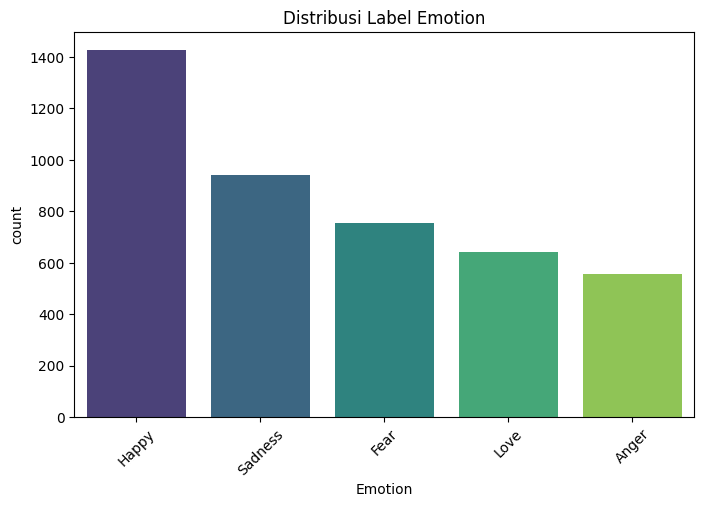

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=train, x='Emotion', order=train['Emotion'].value_counts().index, palette='viridis')
plt.title('Distribusi Label Emotion')
plt.xticks(rotation=45)
plt.show()

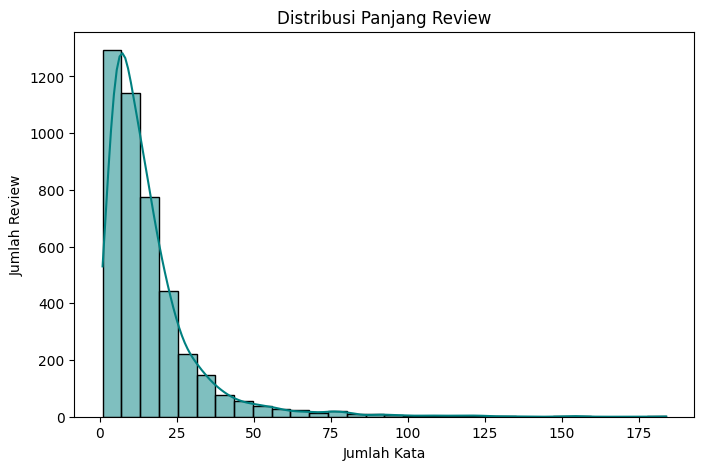

In [ ]:
train['review_length'] = train['Customer Review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(train['review_length'], bins=30, kde=True, color='teal')
plt.title('Distribusi Panjang Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.show()

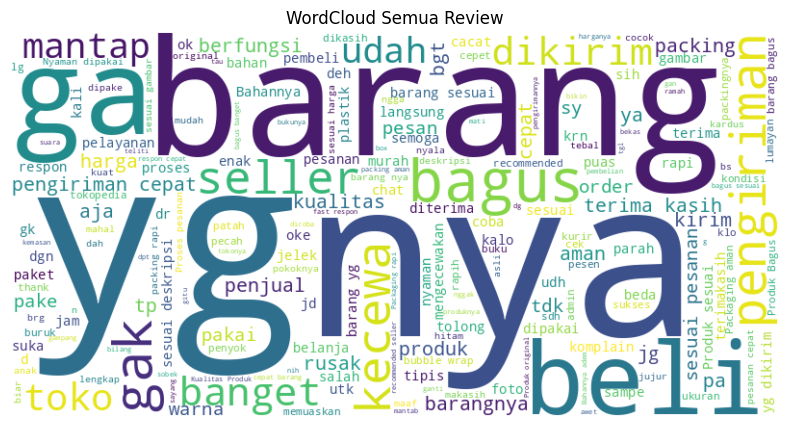

In [ ]:
text = " ".join(review for review in train['Customer Review'].astype(str))

stopwords_id = set(stopwords.words('indonesian'))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_id).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Semua Review')
plt.show()

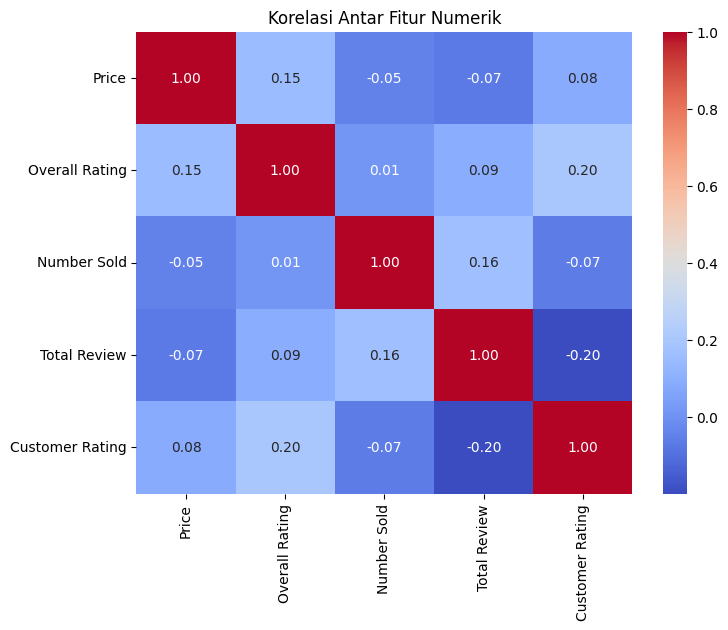

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Fitur Numerik')
plt.show()

In [ ]:
sample_per_emotion = train.groupby('Emotion')['Customer Review'].apply(lambda x: x.sample(1)).reset_index()

print("\nContoh Review per Emosi:")
for idx, row in sample_per_emotion.iterrows():
    print(f"Emotion: {row['Emotion']}")
    print(f"Review: {row['Customer Review']}")
    print("-"*50)


Contoh Review per Emosi:
Emotion: Anger
Review: Jelek! Silikon pelindungnya setelah ditekuk gampang pecah jadi sobek gitu. Kualitas lamounya juga tidak sebaik yg saya bayangkan. Jauh dibawah kualitasnya philips.
--------------------------------------------------
Emotion: Fear
Review: gak sesuai ekspektasi. klo buat simpan barang2 yg agak berat kurang recomended. dan prosesnya lama, klo prosesnya gak sampe 2 hari mungkin sampe lebih cepat kali ya.
--------------------------------------------------
Emotion: Happy
Review: fiturnya cukup bagus sesuai harga
--------------------------------------------------
Emotion: Love
Review: Produk sesuai deskripsi, packing aman terlindung, pengiriman cepat, toko/ penjual responsif, alat sudah dicoba dan berfungsi, sangat direkomendasikan.
--------------------------------------------------
Emotion: Sadness
Review: Barang kurang bagus, bocor dibagian saluran keluar saat di operasikan . ??
--------------------------------------------------


# Pre-Processing

In [ ]:
# Drop Unnamed columns if they exist
train = train.drop(columns=[col for col in train.columns if "Unnamed" in col], errors='ignore')
test = test.drop(columns=[col for col in test.columns if "Unnamed" in col], errors='ignore')

# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special chars and digits
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning
train['Clean_Review'] = train['Customer Review'].apply(clean_text)
test['Clean_Review'] = test['Customer Review'].apply(clean_text)

# Feature Engineering
# Text-based features
def create_text_features(df):
    df['Review_Length'] = df['Customer Review'].apply(lambda x: len(str(x).split()))
    df['Char_Count'] = df['Customer Review'].apply(lambda x: len(str(x)))
    df['Word_Density'] = df['Char_Count'] / (df['Review_Length'] + 1)
    df['Exclamation_Count'] = df['Customer Review'].apply(lambda x: str(x).count('!'))
    df['Question_Count'] = df['Customer Review'].apply(lambda x: str(x).count('?'))
    df['Uppercase_Ratio'] = df['Customer Review'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))

    # Sentiment Analysis using TextBlob
    df['Sentiment_Score'] = df['Customer Review'].apply(get_sentiment)
    return df

def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

# Numeric feature transformations
def create_numeric_features(df):
    # Ratio features
    df['Rating_Price_Ratio'] = df['Customer Rating'] / (df['Price'] + 1)
    df['Review_Sold_Ratio'] = df['Total Review'] / (df['Number Sold'] + 1)

    # Log transformations for skewed features
    for col in ['Price', 'Number Sold', 'Total Review']:
        df[f'Log_{col}'] = np.log1p(df[col])
    return df

# Apply feature engineering
train = create_text_features(train)
test = create_text_features(test)
train = create_numeric_features(train)
test = create_numeric_features(test)

# Prepare features and target
X = train.drop(columns=['Emotion', 'Customer Review'])
y = train['Emotion']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define feature groups
text_feature = 'Clean_Review'
numeric_features = ['Price', 'Overall Rating', 'Number Sold', 'Total Review',
                   'Customer Rating', 'Review_Length', 'Char_Count', 'Word_Density',
                   'Exclamation_Count', 'Question_Count', 'Uppercase_Ratio',
                   'Sentiment_Score', 'Rating_Price_Ratio', 'Review_Sold_Ratio',
                   'Log_Price', 'Log_Number Sold', 'Log_Total Review']
cat_features = ['Category', 'Location']


# Vectorizer

In [ ]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000,
                                ngram_range=(1, 3),  # Use n-grams 1-3
                                min_df=2,            # Minimum docs containing term
                                max_df=0.9,          # Maximum docs containing term (%)
                                sublinear_tf=True),  # Use log scaling
         text_feature),
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='drop'
)


 # Training

In [ ]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# XGBoost with optimized parameters
best_xgb = XGBClassifier(
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=4,
    subsample=0.7,
    colsample_bytree=0.7,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    random_state=42
)

# Final pipeline with preprocessor and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_xgb)
])

# Train the model on the entire training set
pipeline.fit(X, y_encoded)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  max_features=5000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  sublinear_tf=True),
                                                  'Clean_Review'),
                                                 ('num', StandardScaler(),
                                                  ['Price', 'Overall Rating',
                                                   'Number Sold',
                                                   'Total Review',
                                                   'Customer Rating',
                                                   'Review_Length',
                                                   'Char_Count', 'Word_Density',
                                                   'Exclamation_Count',
                                                   'Question_Coun...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

# Evaluation

In [ ]:
# Evaluate with cross-validation
cv_scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring='accuracy')
print(f"Cross-validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Predict on test set
X_test = test.drop(columns=['Customer Review'])
final_pred = pipeline.predict(X_test)
final_pred_labels = le.inverse_transform(final_pred)

Cross-validation Accuracy: 0.7025 ± 0.0121


In [ ]:
# Prepare submission file
sample_solution.rename(columns={'Column1': 'id'}, inplace=True)
sample_solution['Emotion'] = final_pred_labels

# Save to submission.csv
sample_solution.to_csv('/content/submission.csv', index=False)

print("✅ submission.csv successfully saved!")
print(sample_solution.head())

from google.colab import files
files.download("submission.csv")

✅ submission.csv successfully saved!
     id  Emotion
0  5039  Sadness
1  1147     Love
2  3623    Happy
3  4879    Happy
4  4162    Happy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>